# 可视化模型分析

In [17]:
import torch
import torch.nn.functional as F

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))

import argparse
import librosa
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from utilities import create_folder, get_filename
from models import *
from pytorch_utils import move_data_to_device
import config

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

# Model
checkpoint_path = "/root/autodl-nas/2000_iterations.pth"
Model = eval("Cnn10_gf_forgram")
model = Model(sample_rate=config.sample_rate, window_size=config.window_size, 
    hop_size=config.hop_size, mel_bins=config.mel_bins, fmin=config.fmin, fmax=config.fmax, 
    classes_num=config.classes_num, feature_name='mel', learnable='False')

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])

model = model.to(device)

device cuda:0
STFT kernels created, time used = 0.0390 seconds
STFT filter created, time used = 0.0022 seconds
Mel filter created, time used = 0.0022 seconds


In [2]:
import librosa
audio_path = '/root/autodl-nas/data/example.wav'
(waveform, _) = librosa.core.load(audio_path, sr=config.sample_rate, mono=True)
waveform = waveform[:120000]
input_tensor = torch.from_numpy(waveform).unsqueeze(0).to(device) # 预处理
input_tensor.shape

torch.Size([1, 120000])

# 可视化Gabor的输出

In [47]:
out_put = model(input_tensor)

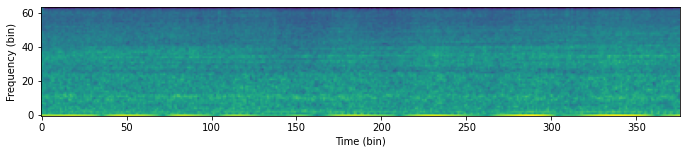

In [56]:
im = np.squeeze(out_put[0].cpu().detach().numpy())
plt.figure(figsize=(12, 2))
plt.imshow(im,origin='lower')
plt.ylabel('Frequency (bin)')
plt.xlabel('Time (bin)')
plt.savefig('test.png')

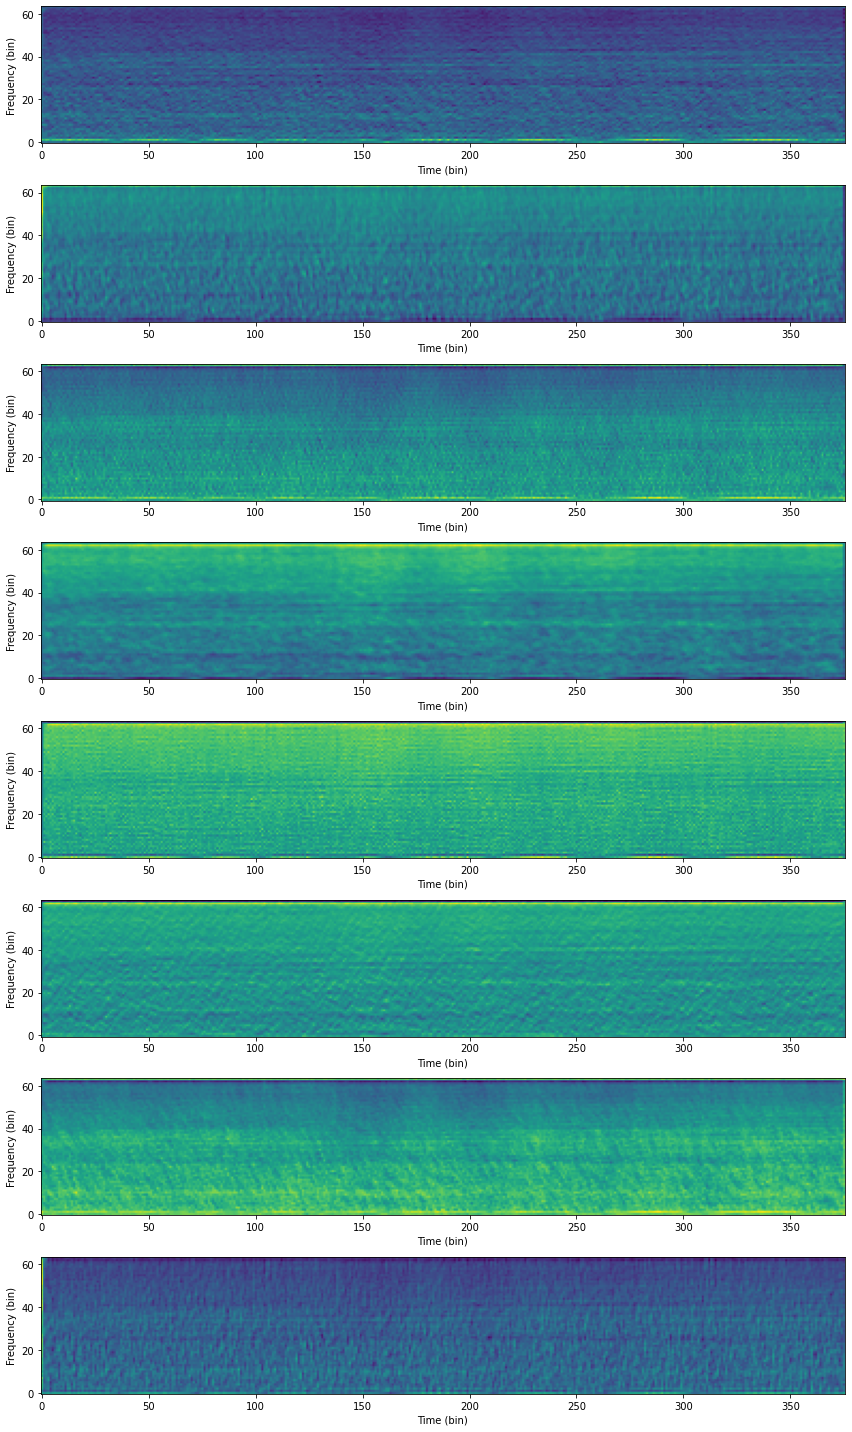

In [61]:
gabor_ims = np.squeeze(out_put[1].cpu().detach().numpy())
plt.figure(figsize=(15, 20))
for i in range(8):
    ax = plt.subplot(8, 1, i+1)
    plt.imshow(gabor_ims[i, :, :].T,origin='lower')
    plt.ylabel('Frequency (bin)')
    plt.xlabel('Time (bin)')
plt.tight_layout()
plt.savefig('test2.png')

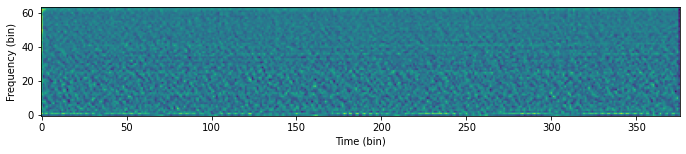

In [58]:
im = np.squeeze(out_put[2].cpu().detach().numpy())
plt.figure(figsize=(12, 2))
plt.imshow(im.T,origin='lower')
plt.ylabel('Frequency (bin)')
plt.xlabel('Time (bin)')
plt.savefig('test3.png')

# 可视化CNN的梯度

In [18]:
import pytorch_grad_cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

In [72]:
from nnAudio import features
import librosa
# plot_gram
def plot_gram(audio_path, checkpoint_path):
    # Input tensor
    (waveform, _) = librosa.core.load(audio_path, sr=config.sample_rate, mono=True)
    waveform = waveform[:48000]
    input_tensor = torch.from_numpy(waveform).unsqueeze(0)
    spec_layer = features.MelSpectrogram(sr=config.sample_rate, n_fft=config.window_size, win_length=config.window_size, fmin=config.fmin, fmax=config.fmax,
                        n_mels=config.mel_bins, hop_length=config.hop_size, window=config.window, center=config.center, pad_mode=config.pad_mode, 
                        power=2.0, htk=False, norm=1, trainable_mel=False, 
                        trainable_STFT=False, verbose=True)
    input_tensor = move_data_to_device(spec_layer(input_tensor), device)
    # Model
    checkpoint_path = "/root/autodl-nas/2000_iterations.pth"
    Model = eval("Cnn10_gf_forgram")
    model = Model(sample_rate=config.sample_rate, window_size=config.window_size, 
        hop_size=config.hop_size, mel_bins=config.mel_bins, fmin=config.fmin, fmax=config.fmax, 
        classes_num=config.classes_num, feature_name='mel', learnable='False')
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    model = model.to(device)
    model.spec_layer = nn.Sequential()
    target_layers = [[model.conv_block1], [model.conv_block2], [model.conv_block3], [model.conv_block4]]
    cam_maps = []
    for target_layer in target_layers:
        cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
        cam_map = cam(input_tensor=input_tensor, targets=None)
        cam_maps.append(cam_map)
    return cam_maps
audio_path = '/root/autodl-nas/data/00003.wav'
cams = []
for i in range(4):
    audio_path = '/root/autodl-nas/data/0000{}.wav'.format(i)
    cam = plot_gram(audio_path, checkpoint_path)
    cams.append(cam)

STFT kernels created, time used = 0.0358 seconds
STFT filter created, time used = 0.0026 seconds
Mel filter created, time used = 0.0026 seconds
STFT kernels created, time used = 0.0393 seconds
STFT filter created, time used = 0.0022 seconds
Mel filter created, time used = 0.0022 seconds
STFT kernels created, time used = 0.0464 seconds
STFT filter created, time used = 0.0037 seconds
Mel filter created, time used = 0.0038 seconds
STFT kernels created, time used = 0.0398 seconds
STFT filter created, time used = 0.0021 seconds
Mel filter created, time used = 0.0021 seconds
STFT kernels created, time used = 0.0405 seconds
STFT filter created, time used = 0.0026 seconds
Mel filter created, time used = 0.0026 seconds
STFT kernels created, time used = 0.0368 seconds
STFT filter created, time used = 0.0033 seconds
Mel filter created, time used = 0.0033 seconds
STFT kernels created, time used = 0.0444 seconds
STFT filter created, time used = 0.0031 seconds
Mel filter created, time used = 0.0032 

<Figure size 432x288 with 0 Axes>

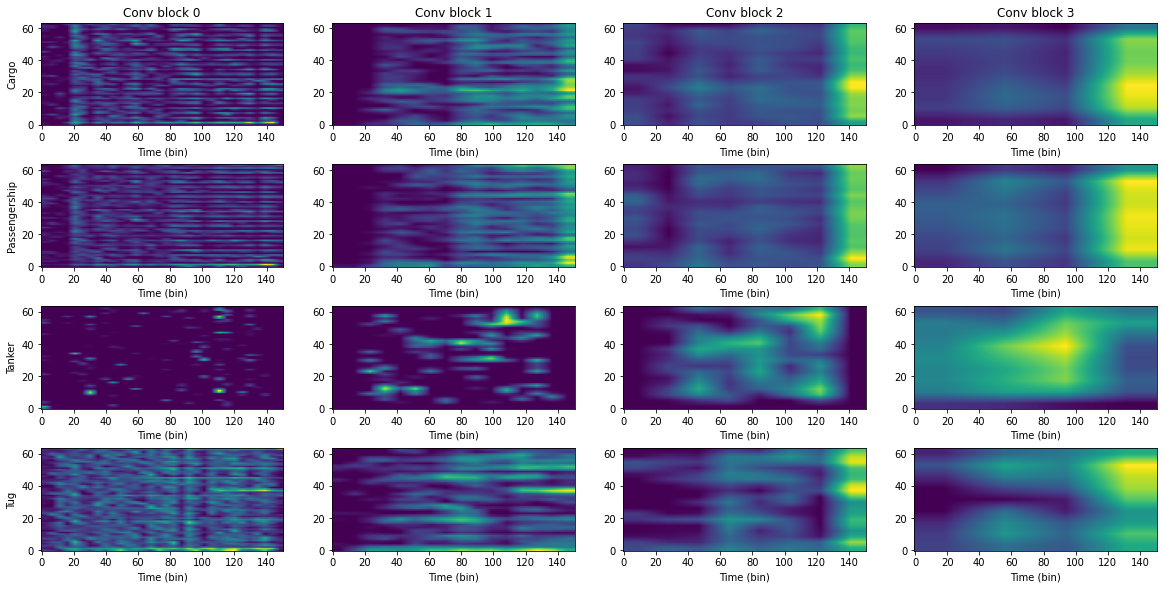

In [73]:
plt.figure()
i = 0
plt.figure(figsize=(20, 10))
title = ['Cargo', 'Passengership', 'Tanker', 'Tug']
for cam in cams:
    for feature_map in cam:
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(feature_map.squeeze(),origin='lower')
        if i%4==0:
            plt.ylabel(title[int(i//4)])
        if i<4:
            plt.title('Conv block {}'.format(i))
        plt.xlabel('Time (bin)')
        i = i+1

In [74]:
def plot_gram(audio_path, checkpoint_path):
    # Input tensor
    (waveform, _) = librosa.core.load(audio_path, sr=config.sample_rate, mono=True)
    waveform = waveform[:48000]
    input_tensor = torch.from_numpy(waveform).unsqueeze(0)
    spec_layer = features.MelSpectrogram(sr=config.sample_rate, n_fft=config.window_size, win_length=config.window_size, fmin=config.fmin, fmax=config.fmax,
                        n_mels=config.mel_bins, hop_length=config.hop_size, window=config.window, center=config.center, pad_mode=config.pad_mode, 
                        power=2.0, htk=False, norm=1, trainable_mel=False, 
                        trainable_STFT=False, verbose=True)
    input_tensor = move_data_to_device(spec_layer(input_tensor), device)
    # Model
    checkpoint_path = "/root/autodl-nas/2000_iterations_Cnn10.pth"
    Model = eval("Cnn10_forgram")
    model = Model(sample_rate=config.sample_rate, window_size=config.window_size, 
        hop_size=config.hop_size, mel_bins=config.mel_bins, fmin=config.fmin, fmax=config.fmax, 
        classes_num=config.classes_num, feature_name='mel', learnable='False')
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    model = model.to(device)
    model.spec_layer = nn.Sequential()
    target_layers = [[model.conv_block1], [model.conv_block2], [model.conv_block3], [model.conv_block4]]
    cam_maps = []
    for target_layer in target_layers:
        cam = GradCAM(model=model, target_layers=target_layer, use_cuda=True)
        cam_map = cam(input_tensor=input_tensor, targets=None)
        cam_maps.append(cam_map)
    return cam_maps
audio_path = '/root/autodl-nas/data/00003.wav'
cams = []
for i in range(4):
    audio_path = '/root/autodl-nas/data/0000{}.wav'.format(i)
    cam = plot_gram(audio_path, checkpoint_path)
    cams.append(cam)

STFT kernels created, time used = 0.0449 seconds
STFT filter created, time used = 0.0042 seconds
Mel filter created, time used = 0.0042 seconds
STFT kernels created, time used = 0.0491 seconds
STFT filter created, time used = 0.0023 seconds
Mel filter created, time used = 0.0024 seconds
STFT kernels created, time used = 0.0349 seconds
STFT filter created, time used = 0.0027 seconds
Mel filter created, time used = 0.0027 seconds
STFT kernels created, time used = 0.0361 seconds
STFT filter created, time used = 0.0021 seconds
Mel filter created, time used = 0.0021 seconds
STFT kernels created, time used = 0.0349 seconds
STFT filter created, time used = 0.0024 seconds
Mel filter created, time used = 0.0025 seconds
STFT kernels created, time used = 0.0352 seconds
STFT filter created, time used = 0.0020 seconds
Mel filter created, time used = 0.0020 seconds
STFT kernels created, time used = 0.0396 seconds
STFT filter created, time used = 0.0026 seconds
Mel filter created, time used = 0.0027 

<Figure size 432x288 with 0 Axes>

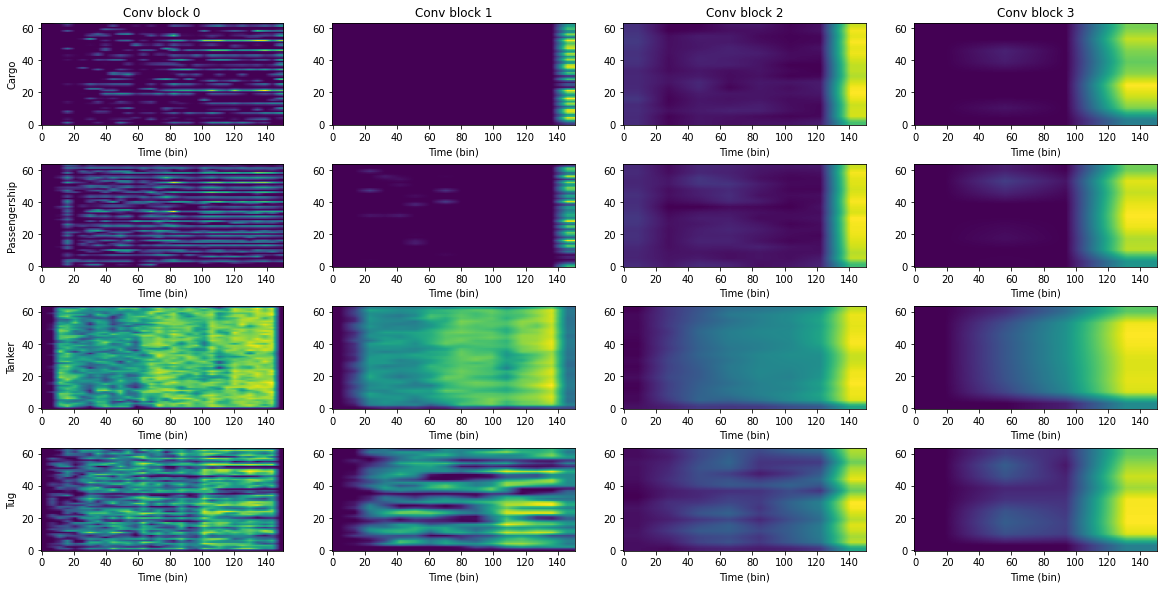

In [76]:
plt.figure()
i = 0
plt.figure(figsize=(20, 10))
title = ['Cargo', 'Passengership', 'Tanker', 'Tug']
for cam in cams:
    for feature_map in cam:
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(feature_map.squeeze(),origin='lower')
        if i%4==0:
            plt.ylabel(title[int(i//4)])
        if i<4:
            plt.title('Conv block {}'.format(i))
        plt.xlabel('Time (bin)')
        i = i+1

# 可视化可学习STFT核

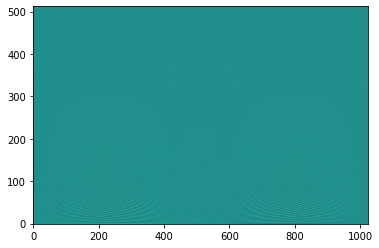

In [10]:
import matplotlib.pyplot as plt
original_basis_real = model.spec_layer.stft.wcos.cpu().detach().numpy().squeeze(1)
original_basis_imag = model.spec_layer.stft.wsin.cpu().detach().numpy().squeeze(1)
plt.imshow(model.spec_layer.stft.wsin.cpu().detach().numpy().squeeze(1), aspect='auto', origin='lower')

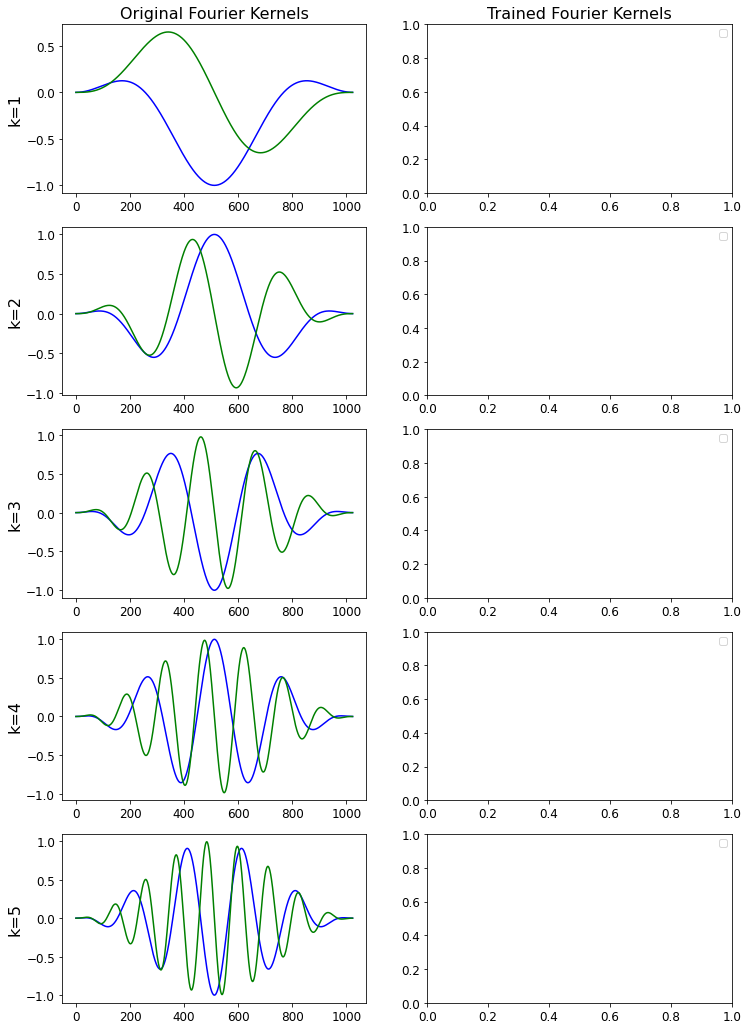

In [12]:
fig, ax = plt.subplots(5,2, figsize=(12,18))
cols = ['Original Fourier Kernels', 'Trained Fourier Kernels']
rows = np.arange(1,6)
for ax_idx, col in zip(ax[0], cols):
    ax_idx.set_title(col, size=16)
for ax_idx, row in zip(ax[:,0], rows):
    ax_idx.set_ylabel(f'k={row}', size=16)    
    

for i in range(5):
    ax[i,0].plot(original_basis_real[i+1], 'b')
    #ax[i,1].plot(trained_basis_real[i+1], 'b')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    
for i in range(5):
    ax[i,0].plot(original_basis_imag[i*2+1], 'g')
    #ax[i,1].plot(trained_basis_imag[i*2+1], 'g')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    ax[i,1].legend(['real','imaginary'])